In [ ]:
#KÉRDÉSEK:
#grid_build nem működik valamiért

In [3]:
if torch.cuda.is_available() is False:
    raise Exception("GPU device not found, runtime environment should be set to GPU")
print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Using GPU device: GeForce RTX 2080 Ti


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import time
from torch_geometric.data import Data, DataLoader
import numpy.linalg as LA
import networkx as nx
from torch_geometric.utils import to_networkx

In [4]:
def build_grid(N):
    start = time.time()
    vertices=x=np.arange(N*N).reshape(N,N)
    edges = []
    edges_w= []
    for i in range(0,vertices.shape[0]-1): #horizontal
        for j in range(0,vertices.shape[1]):
            edges.append([N*i + j, N*(i+1) + j])
            edges_w.append(np.exp(-1))
    
    for i in range(vertices.shape[1]): #vertical
        for j in range(vertices.shape[0]-1):
            edges.append([N*i+j, N*i+j+1])
            edges_w.append(np.exp(-1))
    
    for i in range(0,vertices.shape[0]-1): #diagonal /
        for j in range(1,vertices.shape[1]):
            edges.append([N*i + j, N*(i+1) + j - 1])
            edges_w.append(np.exp(-2))
    
    for i in range(0, vertices.shape[0]-1): #diagonal \
        for j in range(0, vertices.shape[1] - 1):
            edges.append([N*i + j, N*(i+1) + j + 1])
            edges_w.append(np.exp(-2))
    end = time.time()
    print("building time: "+ str(end - start))
    return np.array(edges).transpose(), edges_w

b=build_grid(28)

building time: 0.013601064682006836


In [16]:
np.array(b[0]).shape

(2, 2970)

In [7]:
#too slow, doubles edges

def build_graph(N, L=2):
    start = time.time()
    coord=[[i,j] for i in range(N) for j in range(N)]

    edge_1=[]
    edge_2=[]
    edge_weight=[]
    for i in range(N*N):
        for j in range(N*N):
            if not i==j:
                z=LA.norm(np.array(coord[i])-np.array(coord[j]))
                if float(z)<L:
                    edge_1.append(i)
                    edge_2.append(j)
                    edge_weight.append(np.exp(-z**2))    
    edge_index=[edge_1,edge_2]
    end = time.time()
    print("building time: "+ str(end - start))
    return edge_index, edge_weight
a=build_graph(28)

building time: 18.302900314331055


In [18]:
np.array(a[0]).shape

(2, 5940)

In [23]:
def load_and_transform(train_batch, test_batch, dataset):
    start1 = time.time()
    if dataset=='mnist':
        mnist_train=datasets.MNIST('data', download=True, train=True)
        train_X=mnist_train.train_data/256
        train_y=mnist_train.targets
        mnist_test=datasets.MNIST('data', download=True, train=False)
        test_X=mnist_test.test_data/256
        test_y=mnist_test.targets
        N=28
        in_channel=1
        edge_index, edge_weight= build_graph(N)
        
    if dataset=='cifar':
        cifar_train = datasets.CIFAR10('data',  train=True, download=True)
        train_X= torch.tensor(cifar_train.data/256)
        train_y=torch.tensor(cifar_train.targets)
        cifar_test = datasets.CIFAR10('data', train=False,download=True)
        test_X=torch.tensor(cifar_test.data/256)
        test_y=torch.tensor(cifar_test.targets)
        N=32
        in_channel=3
        edge_index, edge_weight= build_graph(N)
            
    train_list =[]
    test_list=[]
    train_size=train_X.size(0)
    test_size=test_X.size(0)
    
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_weight=torch.tensor(edge_weight).float()
    for i in range(train_size):
        train_list.append(Data(x=train_X[i].view(N*N,in_channel).float(),y=train_y[i], edge_index=edge_index,edge_attr=edge_weight))
        if i<test_size:
            test_list.append(Data(x=test_X[i].view(N*N,in_channel).float(),y=test_y[i], edge_index=edge_index,edge_attr=edge_weight))
    
    train_loader = DataLoader(train_list, batch_size=train_batch)
    test_loader = DataLoader(test_list, batch_size=test_batch)
    end1 = time.time()
    print("loading time: "+ str(end1 - start1))
    return train_loader, test_loader, train_list, test_list

In [8]:
mnist_train=datasets.MNIST('data', download=True, train=True)
train_X=mnist_train.train_data/256
train_y=mnist_train.targets[0]
edge_index = torch.tensor(a[0], dtype=torch.long)
edge_weight=torch.tensor(a[1]).float()
a_data=Data(x=train_X[0].view(28*28,1).float(),y=train_y, edge_index=edge_index,edge_attr=edge_weight)
a_data

edge_index = torch.tensor(b[0], dtype=torch.long)
edge_weight=torch.tensor(b[1]).float()
b_data=Data(x=train_X[0].view(28*28,1).float(),y=train_y, edge_index=edge_index,edge_attr=edge_weight)
b_data

Data(edge_attr=[2970], edge_index=[2, 2970], x=[784, 1], y=5)

Number of nodes: 784
Number of edges: 5940
Average node degree: 15.15
Target value: 5


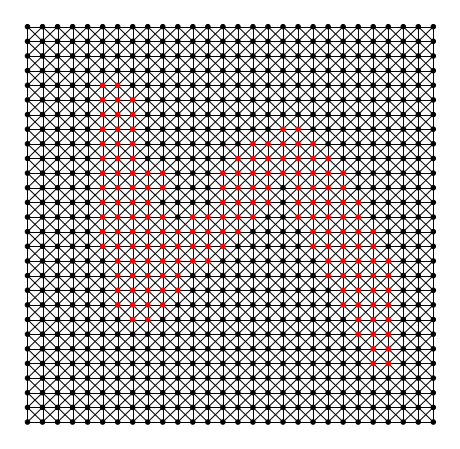

In [15]:
draw_sample(a_data)

In [12]:
def draw_sample(sample):
    color=[]
    for i in sample.x:
        if i>0:
            color.append("red")
        else:
            color.append('black')
    coord=[[i,j] for i in range(28) for j in range(28)]
    pos = {k: tuple(coord[k]) for k in range(28*28)} 
    G = to_networkx(sample, to_undirected=True)
    G=G.to_undirected()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax=nx.draw(G,pos=pos, node_size=20,node_color=color)
    print(f'Number of nodes: {sample.num_nodes}')
    print(f'Number of edges: {sample.num_edges}')
    print(f'Average node degree: {2*sample.num_edges / sample.num_nodes:.2f}')
    print(f'Target value: {sample.y}')

def accuracy(pred, target):
        pred=pred.max(axis=1)[1]
        corrects = 100.0 *torch.eq(pred, target).sum().float() / len(target)
        return corrects.item()

In [16]:
from torch_geometric.nn import ChebConv
class Cheb(nn.Module):
    def __init__(self, in_channel,K,hidden, size):
        super().__init__()
        self.conv1 = ChebConv(in_channel,hidden,K)
        self.dense1 = nn.Linear(size*size*hidden,10)
        self.relu = nn.ReLU()
        self.hidden=hidden
        self.size = size
        self.layers = [self.conv1]
        
        self.history= None
        
    def forward(self, X,edge_index,edge_attr):
        h=X
        for layer in self.layers:
            h = layer(h, edge_index,edge_attr)
            g = self.relu(h)
        h = g.view(-1,self.size*self.size*self.hidden)
        h = self.dense1(h)
        return h,g

In [17]:
def plot_history(history):
    fig = plt.figure(figsize=(15, 5))

    # Plot the loss history
    f1 = fig.add_subplot(121)
    plt.title('Loss')
    plt.plot(history['train_loss'][0], color='blue', label='train')
    plt.xlabel('Batches')
    plt.legend()

    # Plot the accuracy history
    f2 = fig.add_subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(history['train_accuracy'][0], color='blue', label='train')
    plt.xlabel('Batches')
    plt.legend()
    
    plt.show()

In [24]:
def training_loop(BATCH, EPOCHS, MODEL, OPTIMIZER, DATASET):
    
    train_loader, test_loader, train_list, test_list =load_and_transform(BATCH, 1000, DATASET)
    
    criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
    history = {'train_loss': [], 'train_accuracy': [], 'test_loss': [],'test_accuracy': [], 'epoch_loss':
              [], 'epoch_accuracy':[],'time':None}
    
    
    for epoch in range(EPOCHS):
        start=time.time()
        train_loss = []
        train_acc = []
        test_loss = 0
        test_acc = 0
        for step,data in enumerate(train_loader):
            data.to(device)
            OPTIMIZER.zero_grad()  # Clear gradients.
            y_out = MODEL(data.x, data.edge_index, data.edge_attr)[0] # Perform a single forward pass.
            loss = criterion(y_out,  data.y)  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            OPTIMIZER.step()  # Update parameters based on gradients.
            train_loss.append(loss.detach().item())
            train_acc.append(accuracy(y_out, data.y))
            
        epoch_loss=float("{:.2f}".format(sum(train_loss)/(step+1)))
        epoch_acc=float("{:.2f}".format(sum(train_acc)/(step+1)))
        
        for step,data in enumerate(test_loader):
            data.to(device)
            y_out =MODEL(data.x, data.edge_index, data.edge_attr)[0]
            loss = criterion(y_out,  data.y) 
            test_loss += loss.detach().item()
            test_acc += accuracy(y_out, data.y)
        test_loss = test_loss / (step+1)
        test_acc = test_acc / (step+1)
        end=time.time()
        print(f"Epoch: {epoch} | Train loss: {epoch_loss} | Train accuracy: {epoch_acc}  | Test loss: {test_loss} | Test accuracy: {test_acc}| Time: {end-start}")
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['test_accuracy'].append(test_acc)
        history['test_loss'].append(test_loss)
        history['epoch_loss'].append(epoch_loss)
        history['epoch_accuracy'].append(epoch_acc)
        history['time']=end-start
    return history

In [25]:
device = torch.cuda.current_device()
MODEL_Cheb=Cheb(in_channel=1,K=25, hidden=1, size=28).to(device)
OPTIMIZER =  torch.optim.Adam(MODEL_Cheb.parameters(), lr=0.03)   
BATCH = 100
EPOCHS = 10

history = training_loop(BATCH, EPOCHS, MODEL_Cheb, OPTIMIZER, 'mnist')




building time: 9.723660707473755
loading time: 11.409729719161987
Epoch: 0 | Train loss: 0.69 | Train accuracy: 82.21  | Test loss: 0.3704159319400787 | Test accuracy: 89.76000366210937| Time: 33.91826915740967
Epoch: 1 | Train loss: 0.28 | Train accuracy: 91.78  | Test loss: 0.2789855346083641 | Test accuracy: 92.18000564575195| Time: 35.15402436256409
Epoch: 2 | Train loss: 0.24 | Train accuracy: 93.0  | Test loss: 0.23917085006833078 | Test accuracy: 92.79000473022461| Time: 33.748836278915405
Epoch: 3 | Train loss: 0.22 | Train accuracy: 93.55  | Test loss: 0.2396275907754898 | Test accuracy: 92.57000427246093| Time: 34.45135045051575
Epoch: 4 | Train loss: 0.21 | Train accuracy: 93.81  | Test loss: 0.24352772012352944 | Test accuracy: 92.49000473022461| Time: 33.23414206504822
Epoch: 5 | Train loss: 0.21 | Train accuracy: 93.84  | Test loss: 0.2518282562494278 | Test accuracy: 92.1300048828125| Time: 28.780040979385376
Epoch: 6 | Train loss: 0.22 | Train accuracy: 93.7  | Test los

In [16]:
from torchsummary import summary
summary(MODEL_Cheb)

Layer (type:depth-idx)                   Param #
├─ChebConv: 1-1                          260
├─Linear: 1-2                            78,410
├─ReLU: 1-3                              --
Total params: 78,670
Trainable params: 78,670
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─ChebConv: 1-1                          260
├─Linear: 1-2                            78,410
├─ReLU: 1-3                              --
Total params: 78,670
Trainable params: 78,670
Non-trainable params: 0

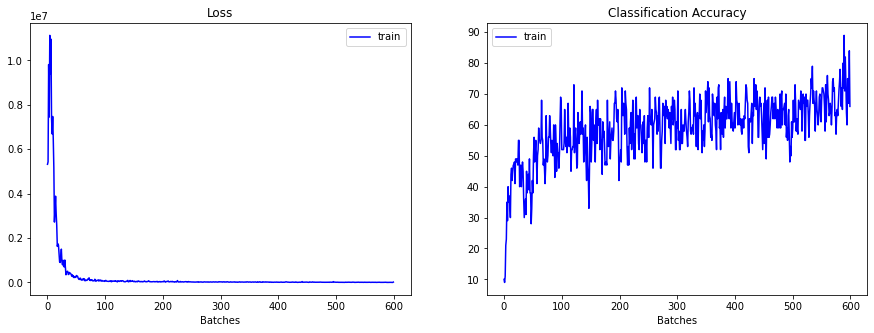

In [32]:
plot_history(history)

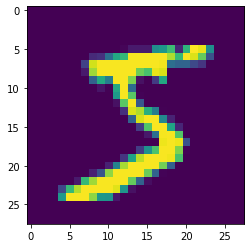

In [29]:

plt.imshow(sample.x.view(28,28).detach().numpy())

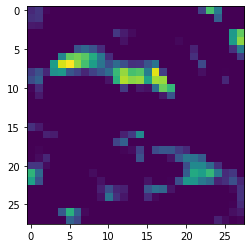

In [33]:
sample=a_data.to(device)
a=MODEL_Cheb(sample.x,sample.edge_index,sample.edge_attr)[1][:,0]
a=a.cpu()
plt.imshow(a.view(28,28).detach().numpy())

In [26]:
sample=train_list[5]
fig, axs = plt.subplots(2, 5)
temp=0
for i in range(2):
    for j in range(5):
        a=MODEL_Cheb(sample.x,sample.edge_index,sample.edge_attr)[1][:,temp]
        axs[i,j].imshow(a.view(28,28).detach().numpy())
        temp=temp+1
sample.y

NameError: name 'train_list' is not defined

In [490]:

BATCH = 100
EPOCHS = 1
DENSITY=2
models={}
START=time.time()
for i in range(1,26):    
    models['Cheb_'+str(i)]=Cheb(i,10)
    OPTIMIZER =  torch.optim.Adam(models['Cheb_'+str(i)].parameters(), lr=0.03)   
    models['Cheb_'+str(i)].history=training_loop(DENSITY, BATCH, EPOCHS, models['Cheb_'+str(i)], OPTIMIZER)
END=time.time()
print(END-START)


building time: 6.151581048965454
loading time: 1.1875615119934082
Epoch: 0 | Train loss: 0.4 | Train accuracy: 88.65  | Test loss: 0.44127815663814546 | Test accuracy: 86.65999984741211| Time: 21.550033807754517
building time: 6.0241334438323975
loading time: 1.2029871940612793
Epoch: 0 | Train loss: 0.36 | Train accuracy: 89.65  | Test loss: 0.3417319476604462 | Test accuracy: 89.59000091552734| Time: 24.386364936828613
building time: 6.09130859375
loading time: 0.8451826572418213
Epoch: 0 | Train loss: 0.36 | Train accuracy: 89.76  | Test loss: 0.3392939239740372 | Test accuracy: 90.0| Time: 27.398553371429443
building time: 6.030961275100708
loading time: 1.2891438007354736
Epoch: 0 | Train loss: 0.31 | Train accuracy: 91.06  | Test loss: 0.24367780834436417 | Test accuracy: 92.95| Time: 30.32615876197815
building time: 6.054934024810791
loading time: 1.1854994297027588
Epoch: 0 | Train loss: 0.32 | Train accuracy: 90.82  | Test loss: 0.3089919835329056 | Test accuracy: 91.099998474

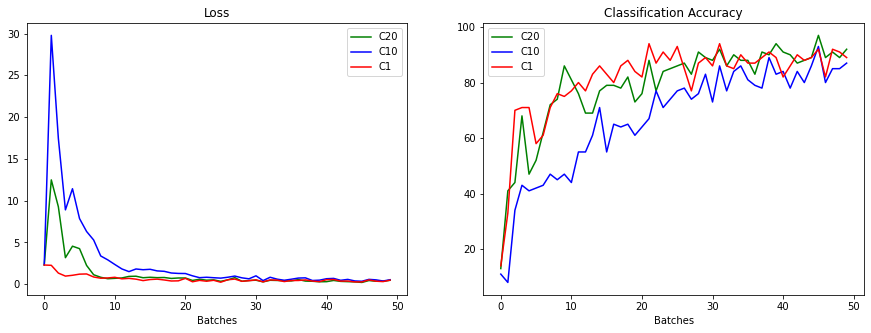

In [496]:
fig = plt.figure(figsize=(15, 5))

    # Plot the loss history
f1 = fig.add_subplot(121)
plt.title('Loss')
plt.plot(models['Cheb_20'].history['train_loss'][0][:50], color='green', label='C20')
plt.plot(models['Cheb_10'].history['train_loss'][0][:50], color='blue', label='C10')
plt.plot(models['Cheb_1'].history['train_loss'][0][:50], color='red', label='C1')
plt.xlabel('Batches')
plt.legend()

f2 = fig.add_subplot(122)
plt.title('Classification Accuracy')
plt.plot(models['Cheb_20'].history['train_accuracy'][0][:50], color='green', label='C20')
plt.plot(models['Cheb_10'].history['train_accuracy'][0][:50], color='blue', label='C10')
plt.plot(models['Cheb_1'].history['train_accuracy'][0][:50], color='red', label='C1')
plt.xlabel('Batches')
plt.legend()

In [590]:
MODEL=Cheb(in_channel=3,K=10, hidden=10, size=32)
OPTIMIZER =  torch.optim.Adam(MODEL.parameters(), lr=0.03)   
BATCH = 100
EPOCHS = 10

history= training_loop(BATCH, EPOCHS, MODEL, OPTIMIZER, 'cifar')


Files already downloaded and verified
Files already downloaded and verified
building time: 6.03476619720459
loading time: 9.84176230430603
Epoch: 0 | Train loss: 2.93 | Train accuracy: 10.29  | Test loss: 2.3042838096618654 | Test accuracy: 10.060000133514404| Time: 85.5934727191925
Epoch: 1 | Train loss: 2.3 | Train accuracy: 10.38  | Test loss: 2.304381775856018 | Test accuracy: 10.050000047683715| Time: 85.77615022659302
Epoch: 2 | Train loss: 2.3 | Train accuracy: 10.08  | Test loss: 2.3018582105636596 | Test accuracy: 10.420000028610229| Time: 85.68987250328064
Epoch: 3 | Train loss: 2.29 | Train accuracy: 11.1  | Test loss: 2.295292687416077 | Test accuracy: 11.360000038146973| Time: 85.81201100349426
Epoch: 4 | Train loss: 2.27 | Train accuracy: 13.57  | Test loss: 2.2567460536956787 | Test accuracy: 15.429999828338623| Time: 85.34819841384888
Epoch: 5 | Train loss: 2.29 | Train accuracy: 10.51  | Test loss: 2.314066219329834 | Test accuracy: 10.240000009536743| Time: 85.3431975

In [28]:
#toy batch
cifar=load_and_transform(100, 1000, 'cifar')
for _,batch in enumerate(cifar[0]):
    x=batch
    break
x    
mnist=load_and_transform(100, 1000, 'mnist')
for _,batch in enumerate(mnist[0]):
    y=batch
    break
y    

Files already downloaded and verified
Files already downloaded and verified
building time: 0.019002199172973633
loading time: 8.194963455200195
building time: 0.013249874114990234
loading time: 2.653409004211426


Batch(batch=[78400], edge_attr=[297000], edge_index=[2, 297000], x=[78400, 1], y=[100])

In [274]:
MODEL=Cheb(in_channel=3,K=1, hidden=10, size=32)
MODEL(x.x,x.edge_index,x.edge_attr)[0][0]

tensor([-0.0745, -0.0372, -0.1536,  0.1581, -0.0239,  0.1478,  0.0183,  0.3014,
        -0.1361,  0.2831], grad_fn=<SelectBackward>)

In [56]:
from torch_geometric.nn import ChebConv
from torch_geometric.nn import BatchNorm
class Cheb_cifar(nn.Module):
    def __init__(self, in_channel,K,hidden, size):
        super().__init__()
        self.conv1 = ChebConv(in_channel,hidden,K)
        self.bn1 = BatchNorm(hidden)
        self.conv2 = ChebConv(hidden,hidden,K)
        self.dense1 = nn.Linear(size*size*hidden,10)
        self.relu = nn.ReLU()
        self.hidden=hidden
        self.size = size
        
        self.history= None
        
    def forward(self, X,edge_index,edge_attr):
        h=X
        
        h = self.conv1(h, edge_index,edge_attr)
        h = self.bn1(h)
        h = self.relu(h)
        h = self.conv2(h, edge_index,edge_attr)
        h = self.relu(h)
        h = h.view(-1,self.size*self.size*self.hidden)
        h = self.dense1(h)
        return h

In [35]:
MODEL_Cifar=Cheb(in_channel=3,K=10, hidden=10, size=32)
OPTIMIZER =  torch.optim.Adam(MODEL_Cifar.parameters(), lr=0.03)   
BATCH = 100
EPOCHS = 10

history = training_loop(BATCH, EPOCHS, MODEL_Cifar, OPTIMIZER, 'cifar')

Files already downloaded and verified
Files already downloaded and verified
building time: 0.01435542106628418
loading time: 7.747766733169556
Epoch: 0 | Train loss: 32.51 | Train accuracy: 20.53  | Test loss: 2.2125873804092406 | Test accuracy: 23.029999923706054| Time: 89.49480700492859
Epoch: 1 | Train loss: 2.1 | Train accuracy: 24.11  | Test loss: 2.1324255228042603 | Test accuracy: 24.119999885559082| Time: 88.4410810470581
Epoch: 2 | Train loss: 2.04 | Train accuracy: 25.82  | Test loss: 2.136669635772705 | Test accuracy: 23.780000305175783| Time: 95.92130970954895
Epoch: 3 | Train loss: 2.01 | Train accuracy: 26.9  | Test loss: 2.145610523223877 | Test accuracy: 24.27999973297119| Time: 108.29806065559387
Epoch: 4 | Train loss: 1.99 | Train accuracy: 27.9  | Test loss: 2.1794234991073607 | Test accuracy: 24.089999961853028| Time: 113.48913669586182


KeyboardInterrupt: 

In [57]:
MODEL_Cifar=Cheb_cifar(in_channel=3,K=10, hidden=10, size=32)
OPTIMIZER =  torch.optim.Adam(MODEL_Cifar.parameters(), lr=0.03)   
BATCH = 100
EPOCHS = 10

history = training_loop(BATCH, EPOCHS, MODEL_Cifar, OPTIMIZER, 'cifar')

Files already downloaded and verified
Files already downloaded and verified
building time: 0.02303767204284668
loading time: 10.840634822845459


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)